## Gaussian Mixture Models and Principal Component Analysis 


In this notebook I show how Gaussian Mixture Models can be used to cluster data. In addition the use of Principal Component Analysis for dimensionality reduction is also investigated. Both of these examples are based on examples provided by scikit-learn using the Iris dataset. The main change is that I use two datasets consisting of audio features for the task of genre classification. They are calculated using Marsyas, an open source software for audio analysis. The first dataset used in the GMM code contains just two song level features (average spectral centroid and average spectral rolloff). That way the data can be visualized directly with a scatter plot. The points are colored in terms of their class membership. There are three genres each represented by a 100 tracks (instances) or points in this case. The genres are classical, jazz and metal. 

The GMM is used to cluster the points without taking into account their genre membership. As can be seen it does  a pretty decent job of recovering the underlying genre structure. 

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


Load the data file and function for drawing ellipses for each of the 3 GMM components. 

In [7]:
colors = ['navy', 'turquoise', 'darkorange']


# draw ellipses for each GMM type 
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)


        
(X, y) = datasets.load_svmlight_file("data/3genres.arff.libsvm")
X = X.toarray()
X = MinMaxScaler().fit_transform(X)
target_names = ['classical', 'jazz', 'metal']

Now let's visualize with some plots different types of GMM based on the constrains placed on the covariance matrix. 

/usr/local/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


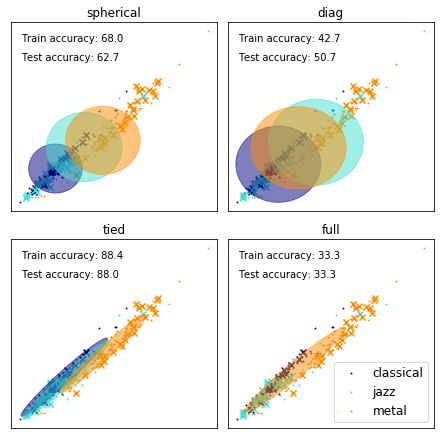

In [11]:

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))

X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = X[y == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()    
    
    

### Principal Component Analysis 

In PCA the data is projected in a lower dimensional space. In this case the data loaded contains a full set of features. There are 300 instances and each instances has 120 features. After PCA we retain the first three PCA directions effectively reducing the dimensionality from 120 to 3. As can be seen from the 3D scatter plot 
where the points are visualized with color based on their corresponding genre, the structure of the data in terms of genre is visible. 

(300, 124)
(300, 3)


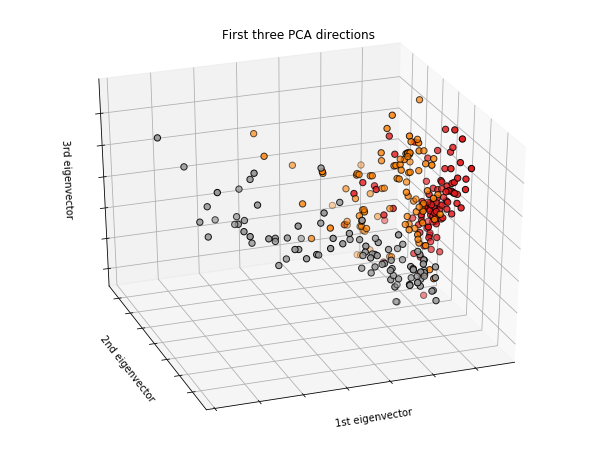

In [15]:
(X, y) = datasets.load_svmlight_file("data/3genres_full.arff.libsvm")
X = X.toarray()
X = MinMaxScaler().fit_transform(X)
target_names = ['classical', 'jazz', 'metal']
print(X.shape)

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
print(X_reduced.shape)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


